In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load in Data

## Edits to code July 30th

In [ ]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt, hilbert

def squeeze_all(data):
    """
    Recursively squeeze all arrays in the dictionary.
    """
    for key, value in data.items():
        if isinstance(value, np.ndarray):
            data[key] = np.squeeze(value)
        elif isinstance(value, dict):
            squeeze_all(value)
    return data

def combine_electrodes(base_dir, session_name):
    session_dir = os.path.join(base_dir, session_name)
    os.chdir(session_dir)

    # Initialize an empty dictionary to store combined data
    combined_data = {}

    # Iterate over each channel file and load the data
    for i in range(1, 129):
        filename = f'ECoG_ch{i}.mat'
        if os.path.exists(filename):
            mat_file = scipy.io.loadmat(filename)
            combined_data[f'channel_{i}'] = np.squeeze(mat_file[f'ECoGData_ch{i}'])

    # Load the ECoGTime.mat file and add it to the combined data
    time_file = 'ECoGTime.mat'
    if os.path.exists(time_file):
        time_data = scipy.io.loadmat(time_file)
        combined_data['ECoGTime'] = np.squeeze(time_data['ECoGTime'])

    # Save the combined data into a new .mat file
    output_filename = f'{session_name}_ECoG_Data.mat'
    scipy.io.savemat(output_filename, combined_data)

    print(f'Combined data saved to {output_filename}')

def load_and_squeeze(base_dir, session_name):
    session_file = os.path.join(base_dir, session_name, f'{session_name}_ECoG_Data.mat')
    data = scipy.io.loadmat(session_file)

    # Squeeze all arrays in the data dictionary
    data = squeeze_all(data)

    return data

def butter_bandpass(lowcut, highcut, fs, order=2):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def data_bands(data, fs, max_freq=250, band_width=4):
    matrix = []
    for lowcut in range(10, max_freq, band_width):
        highcut = lowcut + band_width
        butter_data = butter_bandpass_filter(data, lowcut, highcut, fs)
        matrix.append(butter_data)
    return matrix

def inst_amp(data):
    return np.abs(hilbert(data))

def rms_normalize(data):
    rms = np.sqrt(np.mean(np.square(data), axis=1, keepdims=True))
    return data / rms

def process_data(data, fs, max_freq=250, band_width=4):
    bands_data = data_bands(data, fs, max_freq, band_width)
    normalized_data = [rms_normalize(inst_amp(band)) for band in bands_data]
    return np.array(normalized_data)

def plot_spectrogram(data, ecog_time, fs, channel_num, time_range=None):
    ecog_data = process_data(data, fs)
    bands = np.arange(10, 250, 4)  # Adjust bands to reflect the correct frequency range

    if time_range:
        start_time, end_time = time_range
        start_idx = np.searchsorted(ecog_time, start_time)
        end_idx = np.searchsorted(ecog_time, end_time)
    else:
        start_idx = 0
        end_idx = len(ecog_time)

    fig, ax = plt.subplots()
    cax = ax.imshow(ecog_data[:, start_idx:end_idx], cmap='jet', aspect='auto', origin='lower', extent=[ecog_time[start_idx], ecog_time[end_idx], bands.min(), bands.max()])
    cbar = fig.colorbar(cax)
    cbar.set_label('Inst Amp')

    plt.show()


def plot_grid(base_dir, session_name, channel_nums):
    data = load_and_squeeze(base_dir, session_name)
    ecog_time = data['ECoGTime']
    fs = 1 / (ecog_time[1] - ecog_time[0])

    num_channels = len(channel_nums)
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 5), sharex=True, sharey=True)

    for i, channel_num in enumerate(channel_nums):
        butter_data = butter_bandpass_filter(data[f'channel_{channel_num}'], 0.1, 4, fs)
        axes[i].plot(data['ECoGTime'], butter_data)
        axes[i].set_title(f'Channel {channel_num}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Amplitude')

    plt.xlim(100, 130)
    plt.tight_layout()
    plt.show()




## Load in Data

In [ ]:
# Base directory where sessions are stored
base_dir = '/content/drive/MyDrive/RISE_Data/Ket'

session = 'Session2'  # 'Session1', 'Session2', 'Session3'

# Check if combined data file exists
combined_data_file = os.path.join(base_dir, session, f'{session}_ECoG_Data.mat')
if not os.path.exists(combined_data_file):
    # Process each session to combine electrode data
    combine_electrodes(base_dir, session)

combined_data = load_and_squeeze(base_dir, session)

## Plotting code

In [ ]:
channel_data.shape

(3592471,)

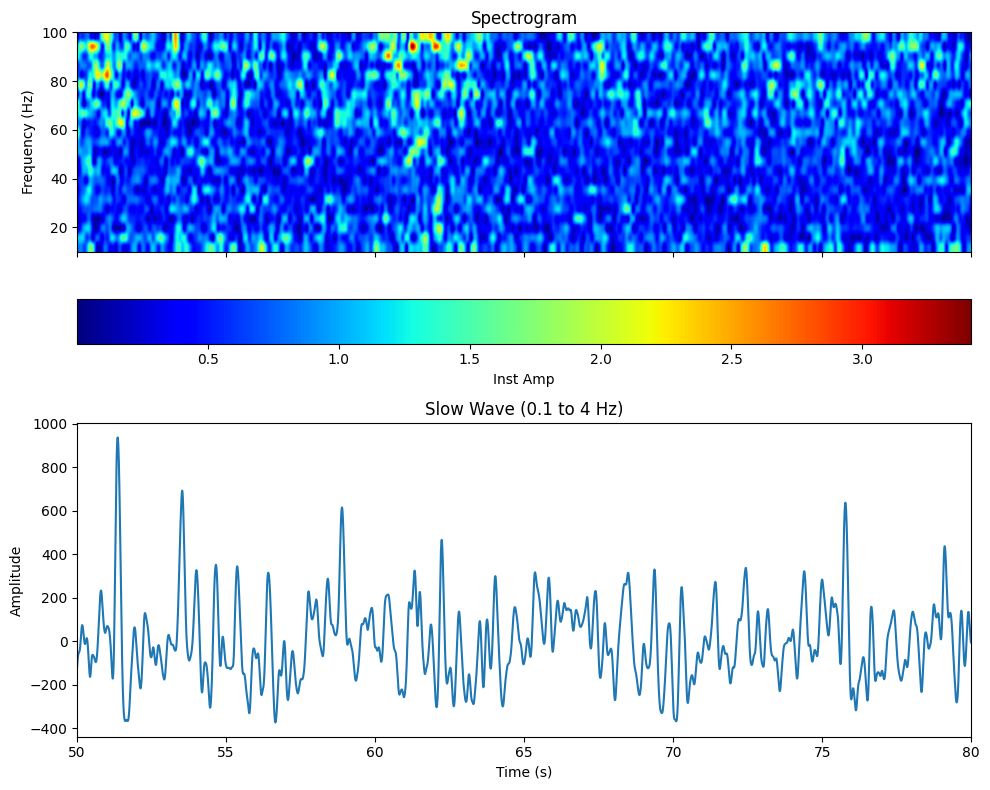

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert

def butter_bandpass(lowcut, highcut, fs, order=2):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def data_bands(data, fs, max_freq=100, band_width=4):
    matrix = []
    for lowcut in range(10, max_freq, band_width):
        highcut = lowcut + band_width
        butter_data = butter_bandpass_filter(data, lowcut, highcut, fs)
        matrix.append(butter_data)
    return np.array(matrix)

def inst_amp(data):
    return np.abs(hilbert(data, axis=-1))

def rms_normalize(data):
    rms = np.sqrt(np.mean(np.square(data), axis=-1, keepdims=True))
    return data / rms

def process_data(data, fs, max_freq=100, band_width=4):
    bands_data = data_bands(data, fs, max_freq, band_width)
    normalized_data = np.array([rms_normalize(inst_amp(band)) for band in bands_data])
    return normalized_data

def plot_spectrogram(data, ecog_time, fs, time_range=None):
    ecog_data = process_data(data, fs)
    #bands = np.arange(10, 100, 4)  # Adjust bands to reflect the correct frequency range

    if time_range:
        start_time, end_time = time_range
        start_idx = np.searchsorted(ecog_time, start_time)
        end_idx = np.searchsorted(ecog_time, end_time)
    else:
        start_idx = 0
        end_idx = len(ecog_time)


    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot spectrogram
    cax = ax1.imshow(ecog_data[:, start_idx:end_idx], cmap='jet', aspect='auto', origin='lower', extent=[ecog_time[start_idx], ecog_time[end_idx], 10, 100])
    cbar = fig.colorbar(cax, ax=ax1, orientation='horizontal')
    cbar.set_label('Inst Amp')
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_title('Spectrogram')

    # Plot slow wave (0.1 to 4 Hz) in time domain
    slow_wave = butter_bandpass_filter(data, 0.1, 4, fs)
    ax2.plot(ecog_time[start_idx:end_idx], slow_wave[start_idx:end_idx])
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    ax2.set_title('Slow Wave (0.1 to 4 Hz)')

    plt.tight_layout()
    plt.savefig('114.100.50-80.png', transparent=True)
    plt.show()

# Base directory where sessions are stored
base_dir = '/content/drive/MyDrive/RISE_Data/Ket'
session = 'Session2'

ecog_time = combined_data['ECoGTime']
fs = 1 / (ecog_time[1] - ecog_time[0])
channel_data = combined_data[f'channel_{114}']

# Plot spectrogram for a specific time range
plot_spectrogram(channel_data, ecog_time, fs, time_range=(50, 80))


normalized data shape (23, 30000)
[-4.35814508e-02  6.26912931e-02  1.57331069e-01 ...  6.17078760e-04
  1.36771583e-04 -4.70862658e-04]


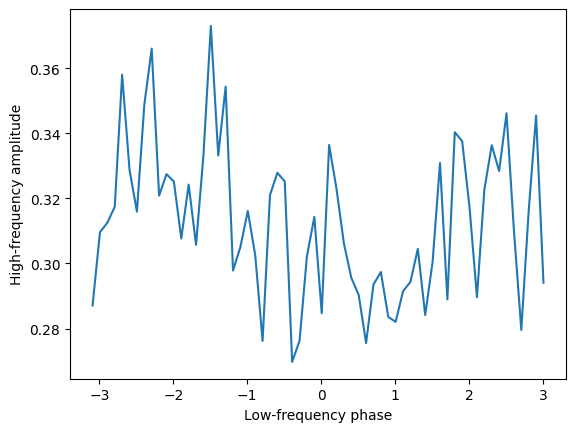

In [ ]:
#PAC
import os
from scipy.signal import hilbert
from scipy.io import loadmat
from scipy import signal
from pylab import *
import numpy as np


def butter_bandpass(lowcut, highcut, fs, order=2):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def data_bands(data, fs, max_freq=100, band_width=4):
    matrix = []
    for lowcut in range(10, max_freq, band_width):
        highcut = lowcut + band_width
        butter_data = butter_bandpass_filter(data, lowcut, highcut, fs)
        matrix.append(butter_data)
    return matrix

def rms_normalize(data):
    rms = np.sqrt(np.mean(np.square(data), keepdims=True))
    return data / rms

def process_data(data, fs, max_freq=100, band_width=4):
    bands_data = data_bands(data, fs, max_freq, band_width)
    normalized_data = []
    for band in bands_data:
      normalized_data.append(rms_normalize(band))

    #sum_data = np.zeros(len(data))
    #print(sum_data)
    # print(sum_data.shape())
    print(f"normalized data shape {np.array(normalized_data).shape}")
    #print("Numpy mean", np.mean(np.array(normalized_data), axis = 0))
    #for band in normalized_data:
      #sum_data = np.array(sum_data) + np.array(band)
    #average_data = np.divide(sum_data, len(bands_data))
    average_data = np.mean(np.array(normalized_data), axis = 0)
    #print(np.array(average_data).shape())
    print(average_data)
    return average_data


def phase_amplitude(data, ecog_time, fs, time_range):

    start_time, end_time = time_range
    start_idx = np.searchsorted(ecog_time, start_time)
    end_idx = np.searchsorted(ecog_time, end_time)

    Vlo = butter_bandpass_filter(data[start_idx:end_idx], 0.1, 4, fs)
    Vhi = process_data(data[start_idx:end_idx], fs)

   #Vhi = butter_bandpass_filter(data[start_idx:end_idx], 10, 14, fs) #why 80??
    phi = np.angle(hilbert(Vlo))  # Compute phase of low-freq signal
    amp = np.abs(hilbert(Vhi))       # Compute amplitude of high-freq signal

    p_bins = np.arange(-pi, pi, 0.1)          # To compute CFC, define phase bins,
    a_mean = np.zeros(size(p_bins)-1)       # ... variable to hold the amplitude,
    p_mean = np.zeros(size(p_bins)-1)       # ... and variable to hold the phase.
    for k in range(np.size(p_bins)-1):      # For each phase bin,
        pL = p_bins[k]                   #... get lower phase limit,
        pR = p_bins[k+1]                 #... get upper phase limit.
        indices = (phi >= pL) & (phi < pR)     #Find phases falling in this bin,
        a_mean[k] = mean(amp[indices])   #... compute mean amplitude,
        p_mean[k] = mean([pL, pR])       #... save center phase.
    plt.plot(p_mean, a_mean)                 #Plot the phase versus amplitude,
    plt.ylabel('High-frequency amplitude')   #... with axes labeled.
    plt.xlabel('Low-frequency phase')
    plt.savefig('pac.45.200-230.png', transparent=True)

    plt.show()



ecog_time = combined_data['ECoGTime']
fs = 1 / (ecog_time[1] - ecog_time[0])
channel_data = combined_data[f'channel_{45}']

phase_amplitude(channel_data, ecog_time, fs, time_range=(200, 230))